In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import joblib


plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [2]:
github_dir = '/home/qzeng_salk_edu/pkg/aging-gene-prediction/ml_output/'
FEATURE_MODALITIES = ['dmr', 'mcg_genebody', 'mch_genebody', 'atac', 'hic_loop', 'hic_abc_dmr', 'hic_abc_peak']
DATA_FEATURE_NAMES = FEATURE_MODALITIES


In [3]:
all_cts = [fp.split('/')[-2] for fp in glob.glob(f"{github_dir}/*/*_perturbed_accuracies.pkl")]
all_cts

['L23_IT_CTX_Glut',
 'Oligo_NN',
 'L6_IT_CTX_Glut',
 'L6_CT_CTX_Glut',
 'CA3_Glut',
 'L5_ET_CTX_Glut',
 'CA1-ProS_Glut',
 'OPC_NN',
 'Astro-TE_NN',
 'DG_Glut']

In [4]:
def get_rt(base_accuracy, perturbed_accuracies):
    fold_value = {}
    rlt = []
    for i in range(5):
        keys = []
        values = []
        tmp_rlt = []
        for modality in FEATURE_MODALITIES:
            for feature_name in perturbed_accuracies[0][modality].keys():
                keys.append(f"{modality}_{feature_name}")
                change = np.array(perturbed_accuracies[i][modality][feature_name][0]) - np.array(base_accuracy[i]) #(perturb - base)
                values.append(change)
            tmpdf = pd.DataFrame(values, columns=['-1', '0', '1'], index = keys)
            tmp_rlt.append(tmpdf)
        tmp_rlt = pd.concat(tmp_rlt, axis = 0)
        rlt.append(tmp_rlt) 

    # count the mean for all tmp_rlt
    rlt = pd.concat(rlt, axis=0)
    rlt['feature'] = rlt.index
    rlt = rlt.groupby('feature').mean().loc[keys]
    return rlt

In [16]:
all_rlt = {}

for ct in all_cts[:10]:
    base_accuracy = joblib.load(f"{github_dir}/{ct}/{ct}_base_accuracies.pkl")
    perturbed_accuracies =joblib.load(f"{github_dir}/{ct}/{ct}_perturbed_accuracies.pkl")
    rlt = get_rt(base_accuracy, perturbed_accuracies)
    all_rlt[ct] = rlt

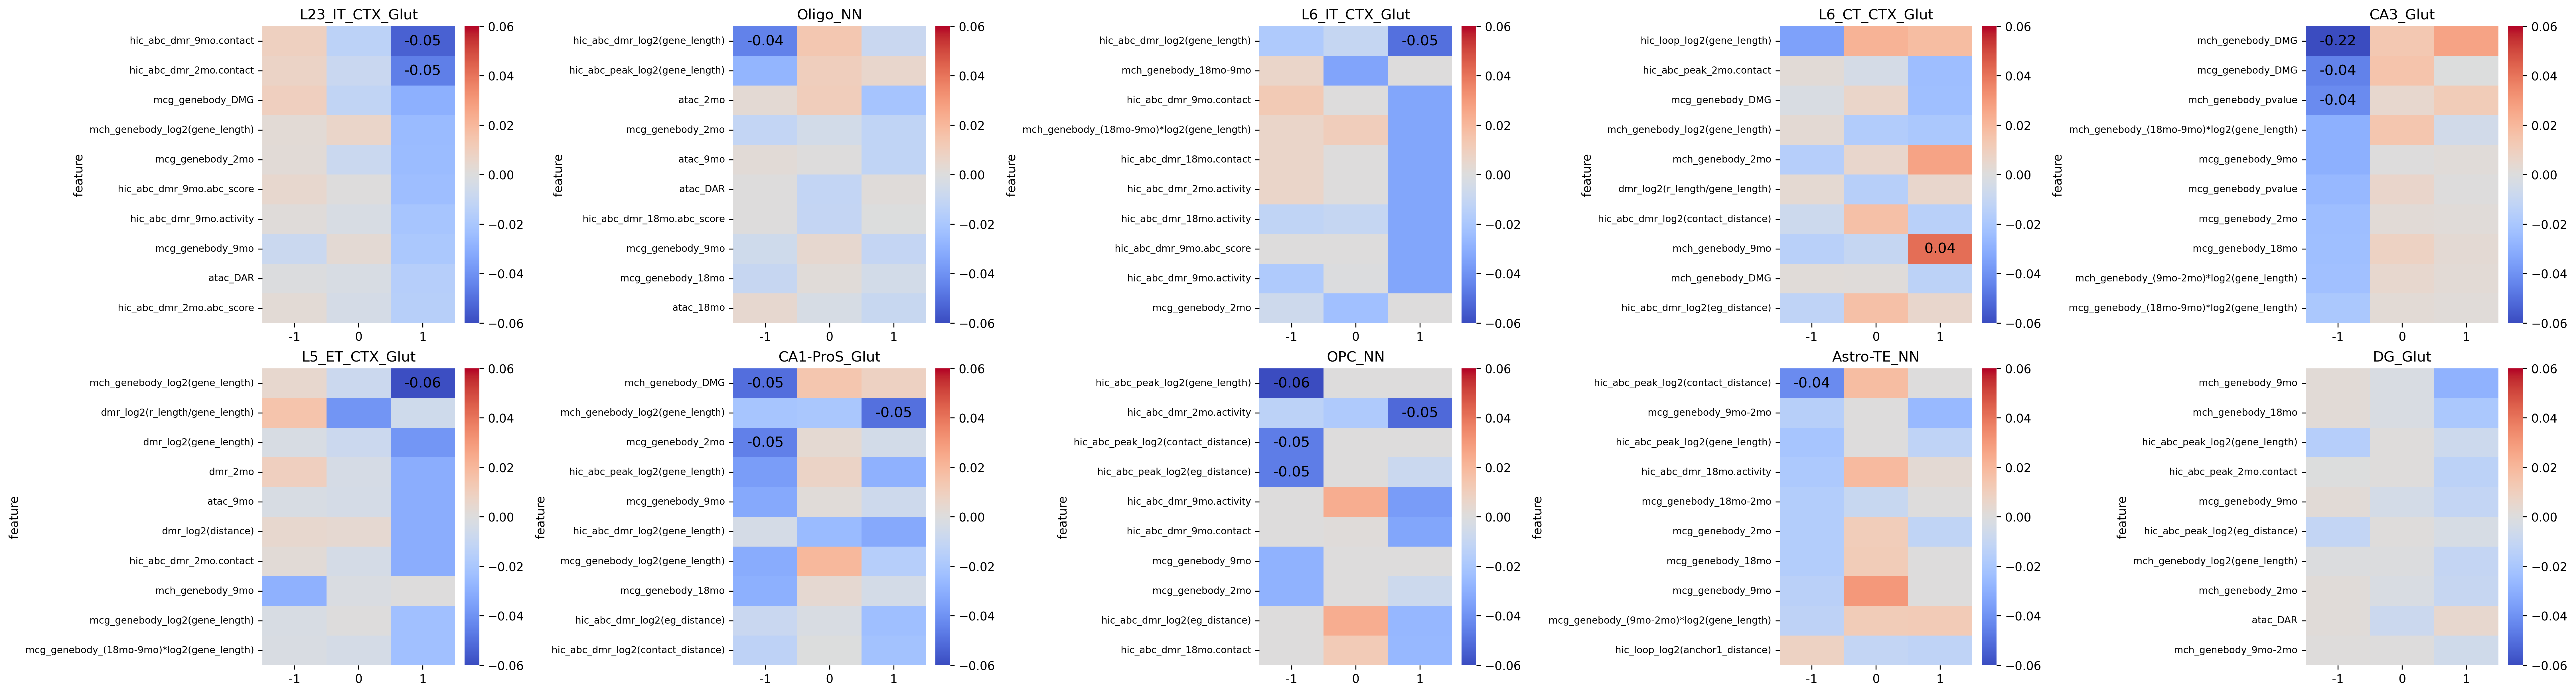

In [29]:
ncols = 5
nrows = 2

fig, axes = plt.subplots(figsize=(ncols*6, nrows*4), ncols = ncols,nrows = nrows, dpi = 300, constrained_layout=True)

for ct, ax in zip(all_cts, axes.ravel()):
    rlt = all_rlt[ct]
    
    rlt['min'] = rlt.min(axis=1)
    toplot = rlt.sort_values('min', ascending=True).head(10)
    # drop min in toplot
    toplot = toplot.drop(columns='min')


   

    sns.heatmap(toplot, 
                annot=False, 
                cmap="coolwarm",  
                center=0, 
                vmin=-0.06,
                vmax=0.06,
                ax=ax)

    for i in range(toplot.shape[0]):
        for j in range(toplot.shape[1]):
            if toplot.iloc[i,j] < -0.04:
                ax.text(j+0.5, i+0.5, round(toplot.iloc[i,j], 2), ha='center', va='center', color='black', fontsize=12)
            elif toplot.iloc[i,j] > 0.04:
                ax.text(j+0.5, i+0.5, round(toplot.iloc[i,j], 2), ha='center', va='center', color='black', fontsize=12)

    ax.set_title(f"{ct}")
    # change y label fontsize
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)